<a href="https://colab.research.google.com/github/arpan031/Image-Captioning-and-Segmentation-System/blob/main/Image_Caption_and_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Main COCO directory
os.makedirs("/content/cocoapi/images/train2017", exist_ok=True)
os.makedirs("/content/cocoapi/images/val2017", exist_ok=True)
os.makedirs("/content/cocoapi/annotations", exist_ok=True)

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O /content/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O /content/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O /content/annotations_trainval2017.zip


--2025-08-31 21:04:38--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.106.84, 16.182.67.89, 3.5.30.212, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.106.84|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘/content/train2017.zip’

/content/train2017. 100%[===================>]  18.01G  40.2MB/s    in 7m 34s  

2025-08-31 21:12:12 (40.6 MB/s) - ‘/content/train2017.zip’ saved [19336861798/19336861798]

--2025-08-31 21:12:12--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.133.9, 54.231.170.97, 3.5.17.112, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.133.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/content/val2017.zip’

/content/val2017.zi 100%[====

In [ ]:
!unzip -q /content/train2017.zip -d /content/cocoapi/images/
!unzip -q /content/val2017.zip -d /content/cocoapi/images/
!unzip -q /content/annotations_trainval2017.zip -d /content/cocoapi/


In [ ]:
!pip install -q pycocotools transformers accelerate timm
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q git+https://github.com/facebookresearch/detectron2.git

import os, random, cv2, json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from transformers import Blip2Processor, Blip2ForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.5 MB/s eta 0:00:00
Device: cuda


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:02, 70.3MB/s]                           


In [ ]:
caption_model_name = "Salesforce/blip2-opt-2.7b"
processor = Blip2Processor.from_pretrained(caption_model_name)
caption_model = Blip2ForConditionalGeneration.from_pretrained(caption_model_name, torch_dtype=torch.float16).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
results_summary = {}

def advanced_demo(img_file, save=True):
    img_path = f"/content/cocoapi/images/val2017/{img_file}"
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # ---- Detectron2 Segmentation ----
    outputs = predictor(image)
    v = Visualizer(image_rgb[:, :, ::-1], scale=1.0, instance_mode=ColorMode.IMAGE)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    seg_vis = v.get_image()[:, :, ::-1]

    # Object counts
    classes = outputs["instances"].pred_classes.cpu().numpy()
    class_counts = {}
    for c in classes:
        class_counts[int(c)] = class_counts.get(int(c), 0) + 1

    # ---- BLIP-2 Captioning ----
    pil_img = Image.open(img_path).convert("RGB")
    inputs = processor(images=pil_img, return_tensors="pt").to(device, torch.float16)

    out = caption_model.generate(
    **inputs,
    max_length=120,     # allow up to ~3 sentences
    min_length=15,      # force a proper complete sentence
    num_beams=6,        # stronger beam search
    early_stopping=True,
    repetition_penalty=1.5,  # reduce rambling
    length_penalty=1.2       # encourage more balanced sentences
  )


    captions = [processor.decode(o, skip_special_tokens=True).strip() for o in out]

    # Post-process: Ensure full sentences
    def fix_caption(c):
        c = c.strip()
        if not c.endswith((".", "!", "?")):
            c += "."
        return c[0].upper() + c[1:]

    captions = [fix_caption(c) for c in captions]

    # ---- Visualization ----
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Left = Original + Captions
    ax[0].imshow(pil_img)
    ax[0].set_title("Captions:\n" + "\n".join([f"- {c}" for c in captions]), fontsize=10)
    ax[0].axis("off")

    # Right = Segmentation
    ax[1].imshow(seg_vis)
    obj_summary = ", ".join([f"{v} x {k}" for k, v in zip(class_counts.keys(), class_counts.values())])
    ax[1].set_title(f"Segmentation\nObjects detected: {len(classes)}", fontsize=10)
    ax[1].axis("off")

    plt.tight_layout()

    if save:
        os.makedirs("/content/results_advanced", exist_ok=True)
        save_path = f"/content/results_advanced/{img_file.replace('.jpg','_adv.jpg')}"
        plt.savefig(save_path)
        print(f"✅ Saved: {save_path}")

        # Save summary
        results_summary[img_file] = {
            "captions": captions,
            "object_count": int(len(classes)),
            "class_counts": {str(k): int(v) for k,v in class_counts.items()}
        }

    plt.show()
    return captions, class_counts


In [ ]:
def batch_advanced(N=5):
    from pycocotools.coco import COCO
    coco = COCO("/content/cocoapi/annotations/instances_val2017.json")
    imgIds = coco.getImgIds()
    sample_imgs = random.sample(imgIds, N)

    for img_id in sample_imgs:
        img_data = coco.loadImgs(img_id)[0]
        advanced_demo(img_file=img_data['file_name'], save=True)

    # Save summary as JSON
    with open("/content/results_advanced/summary.json", "w") as f:
        json.dump(results_summary, f, indent=2)
    print("📄 Summary saved to /content/results_advanced/summary.json")

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


✅ Saved: /content/results_advanced/000000486040_adv.jpg


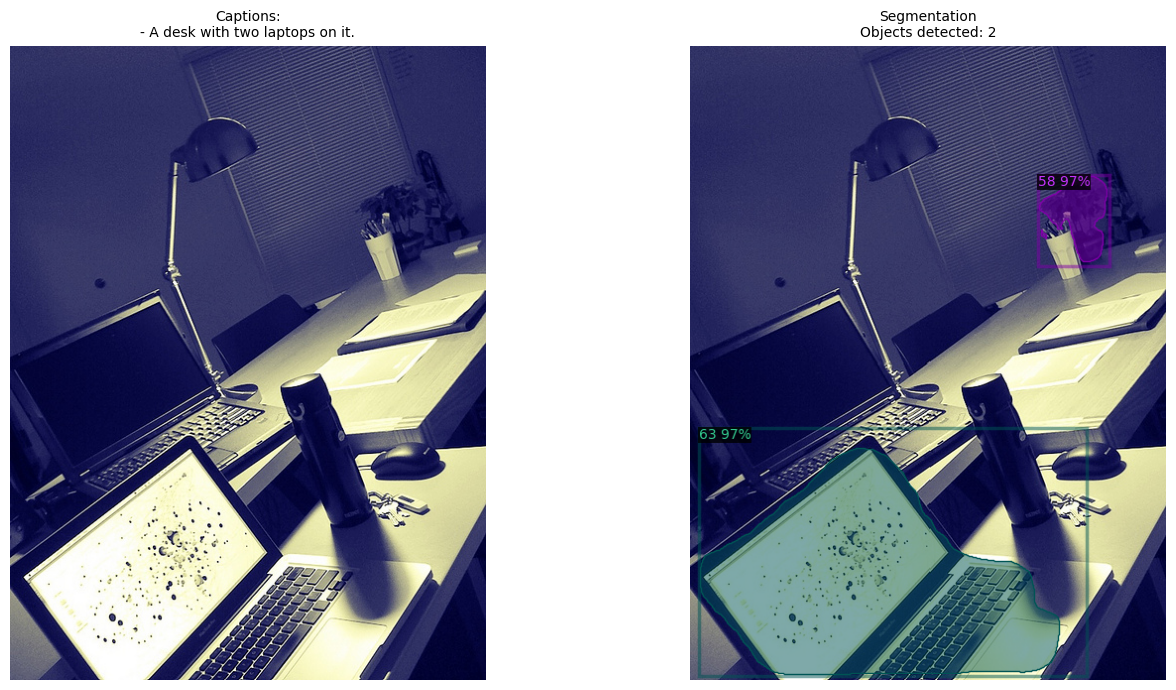

✅ Saved: /content/results_advanced/000000179642_adv.jpg


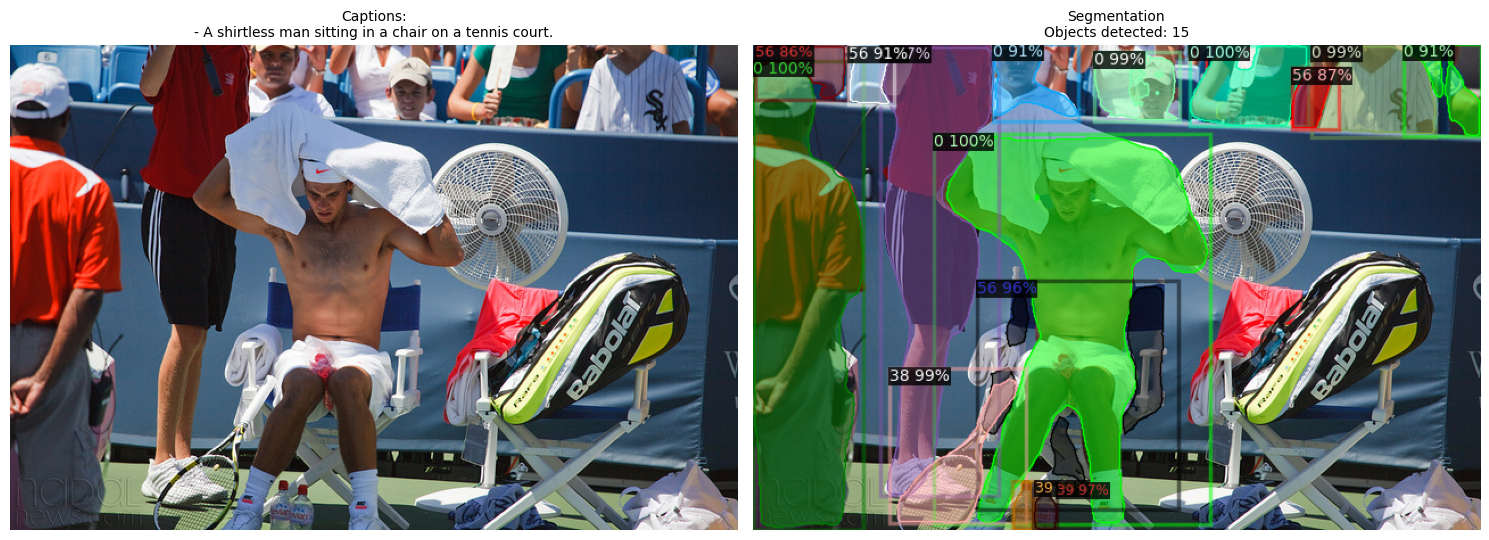

✅ Saved: /content/results_advanced/000000370478_adv.jpg


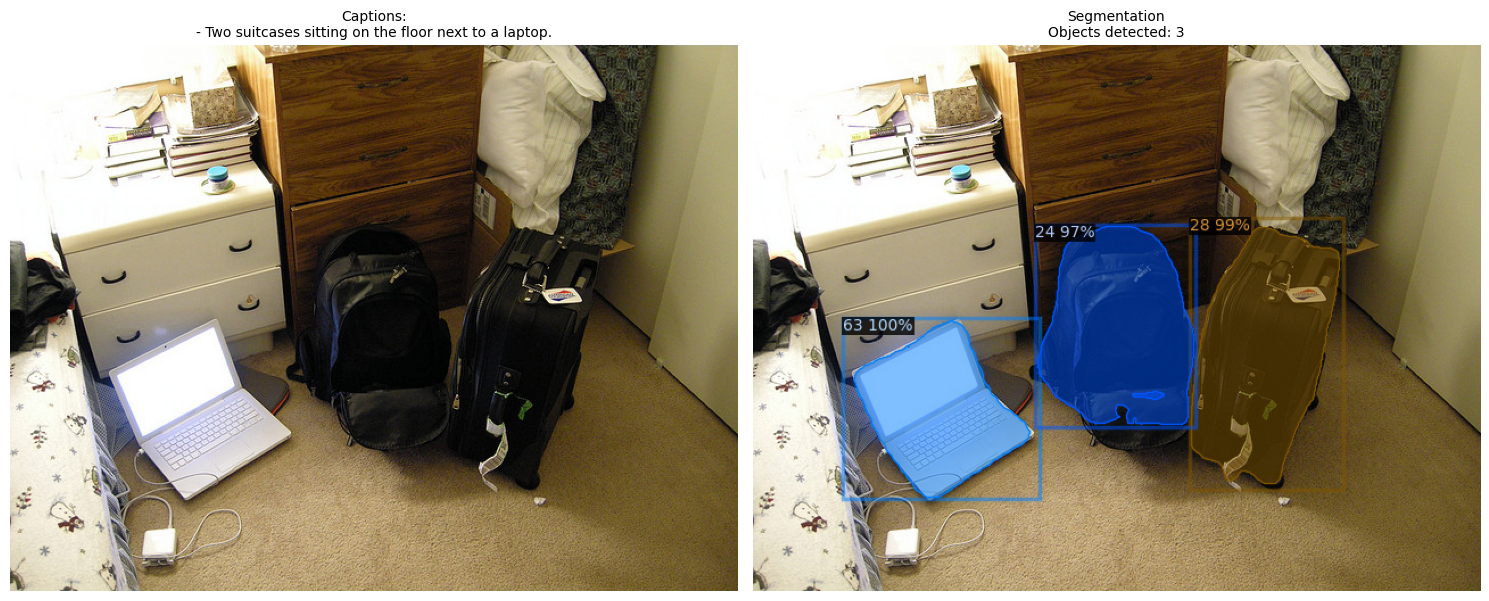

📄 Summary saved to /content/results_advanced/summary.json


In [ ]:
batch_advanced(N=3)  # Change N for more images